# Experiments on contour sampling

In [1]:
import os
import sys
sys.path.append(os.path.abspath("src"))
import torch
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import glob 
from utils import *

#from Datasets.DSB18 import plot_img, Nuclie_data
from torch.utils.data import random_split, DataLoader, dataset

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
points = np.array([17,19, 34,7, 64,7, 86,18, 92,48, 76,35, 72,51, 51,67, 43,43, 34,44, 23,57, 18,78, 7,82, 2,35]).reshape(-1, 2)
x=points[:,0]*280
y=points[:,1]*280

# splprep
This function computes the best curve of degree K, that fits the data (x, y)

We use it here juste to compute the control points of the curve (given that we only have actual points from a polygone)

TCK is the curve representation : T -> 

[-0.30531163 -0.23742183 -0.20061131  0.          0.06544184  0.15978987
  0.23714503  0.33336152  0.398196    0.45006359  0.53309223  0.61265348
  0.64113207  0.69468837  0.76257817  0.79938869  1.          1.06544184
  1.15978987  1.23714503]


C:\Users\mbenimam\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][14]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
C:\Users\mbenimam\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][14]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


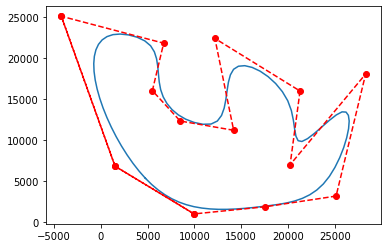

In [3]:
tck,u = interpolate.splprep([x, y],k=3,s=0, per=1)
u=np.linspace(0,1,num=100,endpoint=True)
out = interpolate.splev(u,tck)

t, c, k = tck
print(t)
tck = (t, c, k)
out = interpolate.splev(u,tck)

plt.plot(out[0],out[1])
plt.plot(c[0],c[1], 'ro--')


In [4]:

fig = plt.figure(figsize=(7, 5))
plt.title('B-Spline Evaluation')

x, y = tck[1]

cp = plt.plot(x,y,'k--',label='Control polygon',marker='o',markerfacecolor='red')
line, = plt.plot([],[], 'bo-')
plt.legend(['Control Points', 'Discrete B spline', 'True'],loc='best')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    u3=np.linspace(0,1,i+1,endpoint=True)
    out = interpolate.splev(u3,tck)
    
    line.set_data(out[0], out[1])
    return line,
 
ani = FuncAnimation(fig, animate, init_func=init, frames=100, blit=True, interval=20, repeat=True)
plt.close()
ani.save("animation.mp4")
HTML(ani.to_html5_video())

In [5]:
def sampleBsplineFromControlPoints(controlPoints, numSamples, degree=3):

   k = degree
   t = np.zeros((len(controlPoints)+degree+1))
   t[:degree] = 0
   t[degree:-degree] = np.linspace(0, 1, len(t) - degree*2)
   t[-degree:] = 1   

   def bspline(x, t, c, k):
      n = len(t) - k - 1
      assert (n >= k+1) and (len(c) >= n)
      return np.sum(tuple(c[i] * B(x, k, i, t) for i in range(n)), axis=0)

   u = np.linspace(0, 1, numSamples, endpoint=True)

   return np.array([bspline(x, t, controlPoints, k) for x in u])

def B(x, k, i, t):

      if k == 0:
         return 1.0 if t[i] <= x < t[i+1] else 0.0

      if t[i+k] == t[i]:
         c1 = 0.0

      else:
         c1 = (x - t[i])/(t[i+k] - t[i]) * B(x, k-1, i, t)

      if t[i+k+1] == t[i+1]:
         c2 = 0.0

      else:
         c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B(x, k-1, i+1, t)
      return c1 + c2

def getBsplineMatrix(numSamples=500, degree=3, numControlPoints=18):
    
    m = numControlPoints+degree+1
    knots = np.zeros(m+1)
    knots[1:] = np.arange(1, m+1)/m
    parametrization = np.linspace(knots[degree], knots[numControlPoints], numSamples, endpoint=True)
    # tt, kk = np.meshgrid(T, K)
    B3M = np.zeros((numSamples, numControlPoints))
    for i in range(numControlPoints):
        for j in range(numSamples):
            B3M[j, i] = B(parametrization[j], degree, i, knots)
    return B3M
    
def getSamplesBatch(FM, numSamples=100):
   samples = [sampleBsplineFromControlPoints(FM[i, j, k, :, :], 500, 3) for k in range(FM.shape[2]) for j in range(FM.shape[1]) for i in range(FM.shape[0])]
   return np.array(samples).reshape(-1, FM.shape[1], FM.shape[2], 500, 2)

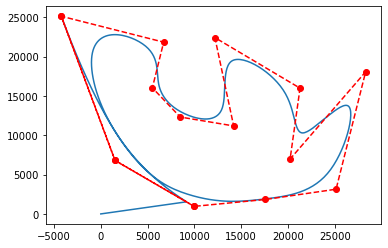

In [6]:

C = np.array(list(zip(c[0],c[1])))
samples = sampleBsplineFromControlPoints(C, 400, 3)
plt.plot(samples[:, 0], samples[:, 1])
plt.plot(C[:, 0],C[:, 1], 'ro--')

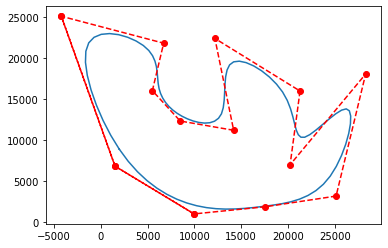

In [7]:
C2 = C
B3M = getBsplineMatrix(numSamples=100, degree=3, numControlPoints=C2.shape[0])
samples = (B3M @ C2)
plt.plot(samples[:, 0], samples[:, 1])
plt.plot(C2[:, 0],C[:, 1], 'ro--')

In [8]:
xx, yy = np.meshgrid(np.arange(128), np.arange(128))
s = np.stack((xx, yy), axis=2)
_C = np.stack(tuple(C*np.random.rand()*5/1000+np.random.rand(2)*50 for i in range(32)), axis=0)
feature_maps = np.stack(tuple(_C for i in range(128*128)), axis=0).reshape(-1, 128, 128, 16, 2)+s[None, :, :, None, :]
feature_maps.shape, B3M.shape

((32, 128, 128, 16, 2), (100, 16))

In [9]:
# %timeit samples = getSamplesBatch(feature_maps, numSamples=100)
B3M = getBsplineMatrix(numSamples=500, degree=3, numControlPoints=16)
%timeit samples = (B3M[None, None, None, :, :] @ feature_maps)
B3M_t = torch.tensor(B3M)
FM_t = torch.tensor(feature_maps)
%timeit samples = torch.tensordot(B3M_t, FM_t, dims=([1], [3]))
torch.cuda.empty_cache()
B3M_t = B3M_t.to("cuda")
FM_t = FM_t.to("cuda")
%timeit samples = torch.tensordot(B3M_t, FM_t, dims=([1], [3]))
# samples = (B3M[None, None, None, :, :] @ feature_maps)

2.17 s ± 58.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
629 ms ± 25.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
91.5 µs ± 25.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


torch.Size([500, 32, 128, 128, 2])


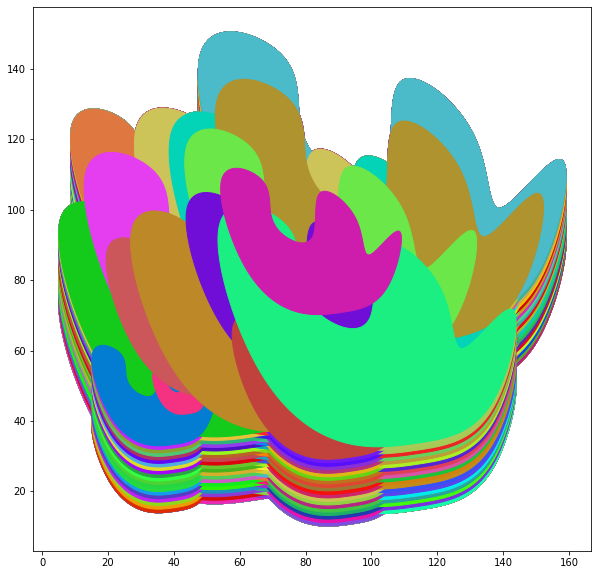

In [10]:
samples = torch.tensordot(B3M_t, FM_t, dims=([1], [3])).cpu()
print(samples.shape)
plt.figure(figsize=(10, 10))
for i in range(samples.shape[1]):
    for x in range(20):
        for y in range(20):
            c = list(map(lambda x: x/255, getRandomColor()))

            plt.fill(samples[:, i, x, y, 0], samples[:, i, x, y, 1], 'o--', color=c)
    # plt.plot(_C[i, :, 0],_C[i, :, 1], 'ro--')